## Telecommunication Sector Model

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import quandl
from sklearn.metrics import mean_absolute_error as mae
from functools import reduce

### Load target variable data

In [2]:
# Load P/E ratio -- data manually downloaded from Capital IQ
pe_ratio = pd.read_csv('PE_daily_normalized_tele.csv')
pe_ratio.head()

,Dates,PE
0,Aug-24-2001,21.84x
1,Aug-27-2001,21.54x
2,Aug-28-2001,21.34x
3,Aug-29-2001,21.16x
4,Aug-30-2001,21.09x


In [3]:
# load telecommunication index price -- also from Capital IQ
price = pd.read_csv('daily_price_tele.csv')
price.head()

,Dates,Value
0,Aug-01-2001,198.68
1,Aug-02-2001,195.27
2,Aug-03-2001,193.28
3,Aug-06-2001,191.48
4,Aug-07-2001,191.19


In [4]:
# load 10 year treasury rate
quandl.ApiConfig.api_key = "xxxxxxxxxxxxx" #apply a quandl api key

treasury = quandl.get("FRED/DGS10")
treasury.head()

,Value
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


### Transform

In [5]:
# rename, change type
pe_ratio = pe_ratio.rename(columns = {"Dates": "Date", "PE" : "PE"})
pe_ratio['Date'] = pd.to_datetime(pe_ratio['Date'])
pe_ratio = pe_ratio.set_index('Date')

pe_ratio['PE'] = pe_ratio['PE'].str.rstrip('x')
pe_ratio['PE'] = pd.to_numeric(pe_ratio['PE'])
pe_ratio.head()

,PE
Date,
2001-08-24,21.84
2001-08-27,21.54
2001-08-28,21.34
2001-08-29,21.16
2001-08-30,21.09


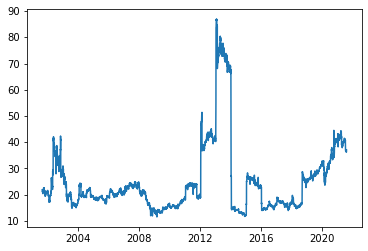

In [6]:
plt.plot(pe_ratio.PE)

In [7]:
# rename, change type
price = price.rename(columns = {"Dates": "Date", "Value" : "Price"})
price['Date'] = pd.to_datetime(price['Date'])
price = price.set_index('Date')
price.head()

,Price
Date,
2001-08-01,198.68
2001-08-02,195.27
2001-08-03,193.28
2001-08-06,191.48
2001-08-07,191.19


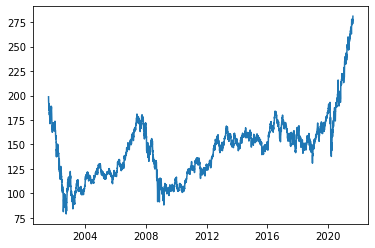

In [8]:
plt.plot(price.Price)

In [9]:
treasury = treasury.rename(columns = {"Value" : "treasury_rate"})
treasury.head()

,treasury_rate
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


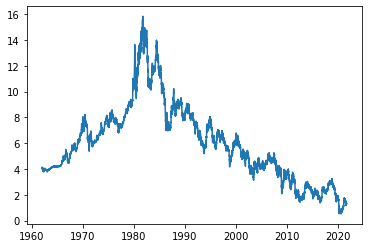

In [10]:
plt.plot(treasury.treasury_rate)

### Transform to monthly average

In [11]:
joined = pe_ratio.join(price).join(treasury)
joined.head()

,PE,Price,treasury_rate
Date,,,
2001-08-24,21.84,183.24,4.93
2001-08-27,21.54,180.65,4.94
2001-08-28,21.34,179.19,4.85
2001-08-29,21.16,177.58,4.78
2001-08-30,21.09,176.92,4.79


In [12]:
joined['month'] = joined.index.month
joined['year'] = joined.index.year

joined = joined.groupby([joined.year, joined.month]).mean()
joined.head()

PE       Price  treasury_rate
year month                                      
2001 8      21.358333  179.221667       4.856667
     9      21.543333  180.474000       4.748667
     10     21.277391  177.617391       4.566818
     11     20.492381  167.864762       4.651500
     12     20.719000  167.026000       5.087500

In [13]:
joined = joined.reset_index()
joined['date'] = pd.to_datetime(joined[['year', 'month']].assign(DAY=1))
joined = joined.set_index('date')
joined.head()

,year,month,PE,Price,treasury_rate
date,,,,,
2001-08-01,2001,8,21.358333,179.221667,4.856667
2001-09-01,2001,9,21.543333,180.474000,4.748667
2001-10-01,2001,10,21.277391,177.617391,4.566818
2001-11-01,2001,11,20.492381,167.864762,4.651500
2001-12-01,2001,12,20.719000,167.026000,5.087500


In [14]:
joined['earnings'] = joined.Price / joined.PE
joined.head()

,year,month,PE,Price,treasury_rate,earnings
date,,,,,,
2001-08-01,2001,8,21.358333,179.221667,4.856667,8.391182
2001-09-01,2001,9,21.543333,180.474000,4.748667,8.377255
2001-10-01,2001,10,21.277391,177.617391,4.566818,8.347705
2001-11-01,2001,11,20.492381,167.864762,4.651500,8.191569
2001-12-01,2001,12,20.719000,167.026000,5.087500,8.061489


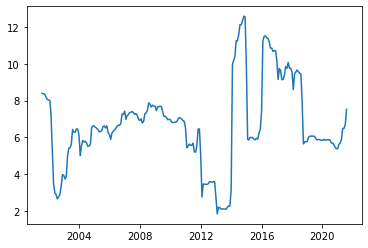

In [15]:
plt.plot(joined.earnings)

In [16]:
joined['earnings_change'] = joined.earnings.pct_change()
display(joined)

,year,month,PE,Price,treasury_rate,earnings,earnings_change
date,,,,,,,
2001-08-01,2001,8,21.358333,179.221667,4.856667,8.391182,NaN
2001-09-01,2001,9,21.543333,180.474000,4.748667,8.377255,-0.001660
2001-10-01,2001,10,21.277391,177.617391,4.566818,8.347705,-0.003527
2001-11-01,2001,11,20.492381,167.864762,4.651500,8.191569,-0.018704
2001-12-01,2001,12,20.719000,167.026000,5.087500,8.061489,-0.015880
...,...,...,...,...,...,...,...
2021-04-01,2021,4,42.774500,251.382000,1.628000,5.876913,0.031792
2021-05-01,2021,5,39.058500,253.229000,1.621000,6.483326,0.103186
2021-06-01,2021,6,40.197368,260.633684,1.524211,6.483849,0.000081


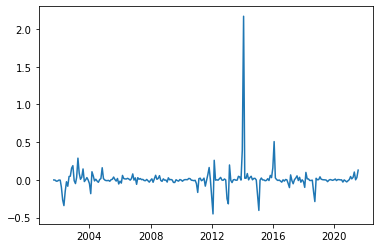

In [17]:
plt.plot(joined.earnings_change)

In [18]:
joined['target'] = joined.earnings_change - ((1 + joined.treasury_rate/100)**(1/12) - 1)
joined = joined.dropna()
joined.head()

,year,month,PE,Price,treasury_rate,earnings,earnings_change,target
date,,,,,,,,
2001-09-01,2001,9,21.543333,180.474000,4.748667,8.377255,-0.001660,-0.005533
2001-10-01,2001,10,21.277391,177.617391,4.566818,8.347705,-0.003527,-0.007256
2001-11-01,2001,11,20.492381,167.864762,4.651500,8.191569,-0.018704,-0.022500
2001-12-01,2001,12,20.719000,167.026000,5.087500,8.061489,-0.015880,-0.020024
2002-01-01,2002,1,20.239048,162.613810,5.035714,8.034657,-0.003328,-0.007431


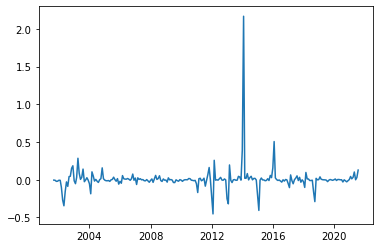

In [19]:
plt.plot(joined.target)

In [20]:
target = joined['target'].to_frame()
target.head()

,target
date,
2001-09-01,-0.005533
2001-10-01,-0.007256
2001-11-01,-0.022500
2001-12-01,-0.020024
2002-01-01,-0.007431


## Load exogenous Variables

In [21]:
def get_df_name(df):
    # grabs name of dataframe to be used as variable name
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def var_change(df):
    df_name = get_df_name(df)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['Date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
    df = df.set_index('Date')

    df = df.rename(columns = {'Value':df_name}).drop(columns = ['year', 'month'])

    df_mom_ch = df.rename(columns = {df_name : df_name + '_mom_ch'})
    df_mom_ch = df_mom_ch[df_name + '_mom_ch'].diff(1)/ df_mom_ch[df_name + '_mom_ch']

    df_yoy_ch = df.rename(columns = {df_name : df_name + '_yoy_ch'})
    df_yoy_ch = df_yoy_ch[df_name + '_yoy_ch'].diff(12)/ df_yoy_ch[df_name + '_yoy_ch']

    df_final = pd.DataFrame(df_mom_ch).join(df_yoy_ch).join(df)
    
    return df_final

## Load Quandl indicators

In [22]:
# CPIAUCSL - Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 
cpi = quandl.get('FRED/CPIAUCSL')
cpi.head()

,Value
Date,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


In [23]:
# WPU117601 - Producer Price Index by Commodity: Machinery and Equipment: Telephone and Wireline Data Networking Equipment
ppi_w = quandl.get('FRED/WPU117601')
ppi_w.head()

,Value
Date,
1985-12-01,100.0
1986-01-01,101.1
1986-02-01,101.1
1986-03-01,101.4
1986-04-01,101.4


In [24]:
# ITMTCIM133S - U.S. Imports of Services: Telecommunications, Computer, and Information Services
imp = quandl.get('FRED/ITMTCIM133S')
imp.head()

,Value
Date,
1999-01-01,1252.0
1999-02-01,1252.0
1999-03-01,1252.0
1999-04-01,1252.0
1999-05-01,1249.0


In [25]:
# ITXTCIM133S - U.S. Exports of Services: Telecommunications, Computer, and Information Services
exp = quandl.get('FRED/ITXTCIM133S')
exp.head()

,Value
Date,
1999-01-01,1019.0
1999-02-01,1018.0
1999-03-01,1016.0
1999-04-01,1012.0
1999-05-01,1011.0


In [26]:
# find month-on-month growth and year-on-year growth
cpi_new = var_change(cpi)
ppi_w_new = var_change(ppi_w)
imp_new = var_change(imp)
exp_new = var_change(exp)

### Joined dataframe

In [27]:
# join all exogenous variables
ex_list = [cpi_new,ppi_w_new,imp_new,exp_new]
ex_merged = reduce(lambda  left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), ex_list)
ex_merged.head()

,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,exp_mom_ch,exp_yoy_ch,exp
Date,,,,,,,,,,,,
1947-01-01,NaN,NaN,21.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-02-01,0.006475,NaN,21.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-03-01,0.017273,NaN,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-04-01,0.000000,NaN,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-05-01,-0.002278,NaN,21.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [28]:
ex_final = ex_merged
ex_final.columns

Index(['cpi_mom_ch', 'cpi_yoy_ch', 'cpi', 'ppi_w_mom_ch', 'ppi_w_yoy_ch',
       'ppi_w', 'imp_mom_ch', 'imp_yoy_ch', 'imp', 'exp_mom_ch', 'exp_yoy_ch',
       'exp'],
      dtype='object')

### Create feature lags

In [29]:
# this lags features in ex_columns in the range of periods in lag_periods

ex_columns = ['cpi_mom_ch', 'cpi_yoy_ch', 'cpi', 'ppi_w_mom_ch', 'ppi_w_yoy_ch',
       'ppi_w', 'imp_mom_ch', 'imp_yoy_ch', 'imp', 'exp_mom_ch', 'exp_yoy_ch',
       'exp']

lag_periods = list(range(1,14))
def add_lags(var_names, lag_periods):
    for var in var_names:
        for lag in lag_periods:
            var_col = var + '_' + str(lag)
            ex_final[var_col] = ex_final[var].shift(lag)
            
add_lags(ex_columns, lag_periods)

In [30]:
st1 = pd.read_csv('one_month_prediction.csv')
st1['Date'] = pd.to_datetime(st1['Date'])
st1 = st1.set_index('Date')
st1['market1'] = pd.to_numeric(st1['market1'])
st1.head()

,market1
Date,
2001-09-01,-0.450016
2001-10-01,-0.414976
2001-11-01,-0.242129
2001-12-01,-0.608143
2002-01-01,-0.612288


In [31]:
st3 = pd.read_csv('three_month_prediction.csv')
st3['Date'] = pd.to_datetime(st3['Date'])
st3 = st3.set_index('Date')
st3['market3'] = pd.to_numeric(st3['market3'])
st3.head()

,market3
Date,
2001-09-01,-0.223276
2001-10-01,-0.050709
2001-11-01,-0.468662
2001-12-01,-0.405413
2002-01-01,-0.290757


In [32]:
st6 = pd.read_csv('six_month_prediction.csv')
st6['Date'] = pd.to_datetime(st6['Date'])
st6 = st6.set_index('Date')
st6['market6'] = pd.to_numeric(st6['market6'])
st6.head()

,market6
Date,
2001-09-01,-0.443436
2001-10-01,-0.613667
2001-11-01,-0.180843
2001-12-01,-0.165990
2002-01-01,-0.090202


In [33]:
st12 = pd.read_csv('twelve_month_prediction.csv')
st12['Date'] = pd.to_datetime(st12['Date'])
st12 = st12.set_index('Date')
st12['market12'] = pd.to_numeric(st12['market12'])
st12.head()

,market12
Date,
2001-09-01,0.105585
2001-10-01,3.037121
2001-11-01,2.871684
2001-12-01,3.588042
2002-01-01,3.011999


In [34]:
# join with target variable

df1 = st1.join(ex_final)
df3 = st3.join(df1)
df6 = st6.join(df3)
df12 = st12.join(df6)
final_df = target.join(df12)
final_df.head()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.005533,0.105585,-0.443436,-0.223276,-0.450016,0.003930,0.025267,178.1,0.000000,-0.056459,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0
2001-10-01,-0.007256,3.037121,-0.613667,-0.050709,-0.414976,-0.002815,0.020833,177.6,0.000000,-0.054545,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0
2001-11-01,-0.022500,2.871684,-0.180843,-0.468662,-0.242129,-0.000563,0.018592,177.5,-0.001918,-0.056568,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0
2001-12-01,-0.020024,3.588042,-0.165990,-0.405413,-0.608143,-0.000564,0.015784,177.4,0.000000,-0.056568,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0
2002-01-01,-0.007431,3.011999,-0.090202,-0.290757,-0.612288,0.001688,0.011818,177.7,-0.000960,-0.057582,...,1059.0,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0


In [35]:
# look at any NAs
final_df[final_df.isna().any(1)]

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
date,,,,,,,,,,,,,,,,,,,,,
2021-04-01,0.030445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-01,0.101845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01,-0.001181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-01,0.028076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-01,0.127284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
# remove latest periods with missing data
df = final_df.iloc[:-5]
df.tail()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
date,,,,,,,,,,,,,,,,,,,,,
2020-11-01,-0.028466,-0.023348,0.227182,0.027331,0.009809,0.001782,0.011260,260.927,0.008424,0.007220,...,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0
2020-12-01,-0.014038,-0.017484,0.183293,0.016424,-0.000538,0.002420,0.012835,261.560,0.003597,0.007194,...,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0
2021-01-01,0.001549,-0.051593,0.089681,0.004035,-0.000172,0.002559,0.013515,262.231,-0.009685,0.013317,...,4647.0,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0
2021-02-01,0.042618,0.519621,-0.001906,-0.000868,-0.000759,0.003534,0.016480,263.161,0.003619,0.007238,...,4989.0,4647.0,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0
2021-03-01,0.011291,0.854688,-0.007756,-0.000918,-0.000566,0.006163,0.025696,264.793,-0.004848,-0.003636,...,5208.0,4989.0,4647.0,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0


## Feature Correlation

In [37]:
var_corr = (df.corr().sort_values('target'))
var_corr.tail()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
imp_mom_ch_9,0.115069,-0.099829,0.228851,-0.009685,0.128413,0.002008,0.247684,-0.162923,0.048076,-0.014429,...,-0.204432,-0.206871,-0.208526,-0.209764,-0.212314,-0.217074,-0.223293,-0.230087,-0.236462,-0.242000
ppi_w_yoy_ch_1,0.120972,-0.317144,-0.169814,-0.274051,-0.293096,-0.058252,-0.169810,0.687145,0.010201,0.918835,...,0.594803,0.592308,0.589509,0.586828,0.584508,0.582323,0.580177,0.577924,0.575895,0.574192
ppi_w_yoy_ch_2,0.124468,-0.310059,-0.150986,-0.259903,-0.290504,-0.010634,-0.160093,0.690214,0.010328,0.850089,...,0.597571,0.595455,0.592796,0.589918,0.587282,0.584981,0.582743,0.580574,0.578313,0.576281
imp_mom_ch_10,0.144623,-0.069538,0.165337,0.010657,0.069834,-0.010904,0.214157,-0.151209,0.057236,-0.002626,...,-0.190591,-0.192365,-0.195366,-0.197969,-0.199758,-0.202409,-0.206816,-0.212779,-0.219391,-0.225716
target,1.000000,-0.002682,0.067225,0.005044,-0.048456,-0.058515,-0.014914,0.028942,0.055558,0.108407,...,0.026239,0.022830,0.020253,0.018561,0.017770,0.017399,0.017369,0.017417,0.017542,0.018226


In [38]:
var_corr

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
cpi_yoy_ch_10,-0.123838,0.251815,-0.199322,-0.337079,-0.243939,0.040154,0.084825,-0.288416,-0.013268,-0.105062,...,-0.314906,-0.315794,-0.316017,-0.316065,-0.315495,-0.313947,-0.311834,-0.310461,-0.310772,-0.312688
cpi_yoy_ch_11,-0.102447,0.261622,-0.280032,-0.300085,-0.228583,0.022016,0.005331,-0.285688,-0.019186,-0.097925,...,-0.306699,-0.308990,-0.310439,-0.311716,-0.312395,-0.311932,-0.309920,-0.307441,-0.305779,-0.305974
cpi_yoy_ch_9,-0.100167,0.258466,-0.113470,-0.352466,-0.272079,0.029977,0.157066,-0.288958,-0.026632,-0.114132,...,-0.318254,-0.318224,-0.317732,-0.316817,-0.315210,-0.313360,-0.312186,-0.312646,-0.314615,-0.317517
cpi_mom_ch_11,-0.092327,0.066391,0.089854,-0.158871,-0.067938,0.037886,0.266680,-0.109432,0.005623,-0.043596,...,-0.131790,-0.128644,-0.124579,-0.121068,-0.118053,-0.116282,-0.116383,-0.119396,-0.124691,-0.130857
cpi_mom_ch_10,-0.092012,0.000854,0.122231,-0.172117,-0.104800,0.057273,0.363114,-0.116181,0.037491,-0.082860,...,-0.135796,-0.131358,-0.127133,-0.123702,-0.121867,-0.122276,-0.125514,-0.130968,-0.137174,-0.141921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
imp_mom_ch_9,0.115069,-0.099829,0.228851,-0.009685,0.128413,0.002008,0.247684,-0.162923,0.048076,-0.014429,...,-0.204432,-0.206871,-0.208526,-0.209764,-0.212314,-0.217074,-0.223293,-0.230087,-0.236462,-0.242000
ppi_w_yoy_ch_1,0.120972,-0.317144,-0.169814,-0.274051,-0.293096,-0.058252,-0.169810,0.687145,0.010201,0.918835,...,0.594803,0.592308,0.589509,0.586828,0.584508,0.582323,0.580177,0.577924,0.575895,0.574192
ppi_w_yoy_ch_2,0.124468,-0.310059,-0.150986,-0.259903,-0.290504,-0.010634,-0.160093,0.690214,0.010328,0.850089,...,0.597571,0.595455,0.592796,0.589918,0.587282,0.584981,0.582743,0.580574,0.578313,0.576281
imp_mom_ch_10,0.144623,-0.069538,0.165337,0.010657,0.069834,-0.010904,0.214157,-0.151209,0.057236,-0.002626,...,-0.190591,-0.192365,-0.195366,-0.197969,-0.199758,-0.202409,-0.206816,-0.212779,-0.219391,-0.225716


## Shift target variables for 1, 3, 6, 12, 18 months

In [39]:
df_1 = df
df_1 = df_1.reset_index()
df_1['target'] = df_1.target.shift(-1)
df_1['date'] = df_1.date + pd.DateOffset(months = 1)
df_1 = df_1.set_index('date')
df_1 = df_1[df_1.index >= target.index[0]]
df_1['month'] = df_1.index.month
df_1

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-10-01,-0.007256,0.105585,-0.443436,-0.223276,-0.450016,0.003930,0.025267,178.100,0.000000,-0.056459,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,10
2001-11-01,-0.022500,3.037121,-0.613667,-0.050709,-0.414976,-0.002815,0.020833,177.600,0.000000,-0.054545,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,11
2001-12-01,-0.020024,2.871684,-0.180843,-0.468662,-0.242129,-0.000563,0.018592,177.500,-0.001918,-0.056568,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,12
2002-01-01,-0.007431,3.588042,-0.165990,-0.405413,-0.608143,-0.000564,0.015784,177.400,0.000000,-0.056568,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1
2002-02-01,-0.008379,3.011999,-0.090202,-0.290757,-0.612288,0.001688,0.011818,177.700,-0.000960,-0.057582,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-01,-0.014038,-0.023348,0.227182,0.027331,0.009809,0.001782,0.011260,260.927,0.008424,0.007220,...,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,12
2021-01-01,0.001549,-0.017484,0.183293,0.016424,-0.000538,0.002420,0.012835,261.560,0.003597,0.007194,...,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,1
2021-02-01,0.042618,-0.051593,0.089681,0.004035,-0.000172,0.002559,0.013515,262.231,-0.009685,0.013317,...,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,2


In [40]:
df_3 = df
df_3 = df_3.reset_index()
df_3['target'] = df_3.target.shift(-3)
df_3['date'] = df_3.date + pd.DateOffset(months = 3)
df_3 = df_3.set_index('date')
df_3 = df_3[df_3.index >= target.index[0]]
df_3['month'] = df_3.index.month
df_3

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-12-01,-0.020024,0.105585,-0.443436,-0.223276,-0.450016,0.003930,0.025267,178.100,0.000000,-0.056459,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,12
2002-01-01,-0.007431,3.037121,-0.613667,-0.050709,-0.414976,-0.002815,0.020833,177.600,0.000000,-0.054545,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1
2002-02-01,-0.008379,2.871684,-0.180843,-0.468662,-0.242129,-0.000563,0.018592,177.500,-0.001918,-0.056568,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,2
2002-03-01,-0.099550,3.588042,-0.165990,-0.405413,-0.608143,-0.000564,0.015784,177.400,0.000000,-0.056568,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,3
2002-04-01,-0.270032,3.011999,-0.090202,-0.290757,-0.612288,0.001688,0.011818,177.700,-0.000960,-0.057582,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.042618,-0.023348,0.227182,0.027331,0.009809,0.001782,0.011260,260.927,0.008424,0.007220,...,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,2
2021-03-01,0.011291,-0.017484,0.183293,0.016424,-0.000538,0.002420,0.012835,261.560,0.003597,0.007194,...,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,3
2021-04-01,NaN,-0.051593,0.089681,0.004035,-0.000172,0.002559,0.013515,262.231,-0.009685,0.013317,...,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4


In [41]:
df_6 = df
df_6 = df_6.reset_index()
df_6['target'] = df_6.target.shift(-6)
df_6['date'] = df_6.date + pd.DateOffset(months = 6)
df_6 = df_6.set_index('date')
df_6 = df_6[df_6.index >= target.index[0]]
df_6['month'] = df_6.index.month
df_6

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2002-03-01,-0.099550,0.105585,-0.443436,-0.223276,-0.450016,0.003930,0.025267,178.100,0.000000,-0.056459,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,3
2002-04-01,-0.270032,3.037121,-0.613667,-0.050709,-0.414976,-0.002815,0.020833,177.600,0.000000,-0.054545,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,4
2002-05-01,-0.346031,2.871684,-0.180843,-0.468662,-0.242129,-0.000563,0.018592,177.500,-0.001918,-0.056568,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,5
2002-06-01,-0.156167,3.588042,-0.165990,-0.405413,-0.608143,-0.000564,0.015784,177.400,0.000000,-0.056568,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,6
2002-07-01,-0.029472,3.011999,-0.090202,-0.290757,-0.612288,0.001688,0.011818,177.700,-0.000960,-0.057582,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-01,NaN,-0.023348,0.227182,0.027331,0.009809,0.001782,0.011260,260.927,0.008424,0.007220,...,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,5
2021-06-01,NaN,-0.017484,0.183293,0.016424,-0.000538,0.002420,0.012835,261.560,0.003597,0.007194,...,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,6
2021-07-01,NaN,-0.051593,0.089681,0.004035,-0.000172,0.002559,0.013515,262.231,-0.009685,0.013317,...,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,7


In [42]:
df_12 = df
df_12 = df_12.reset_index()
df_12['target'] = df_12.target.shift(-12)
df_12['date'] = df_12.date + pd.DateOffset(months = 12)
df_12 = df_12.set_index('date')
df_12 = df_12[df_12.index >= target.index[0]]
df_12['month'] = df_12.index.month
df_12

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2002-09-01,0.040499,0.105585,-0.443436,-0.223276,-0.450016,0.003930,0.025267,178.100,0.000000,-0.056459,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,9
2002-10-01,0.045425,3.037121,-0.613667,-0.050709,-0.414976,-0.002815,0.020833,177.600,0.000000,-0.054545,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,10
2002-11-01,0.151730,2.871684,-0.180843,-0.468662,-0.242129,-0.000563,0.018592,177.500,-0.001918,-0.056568,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,11
2002-12-01,0.184430,3.588042,-0.165990,-0.405413,-0.608143,-0.000564,0.015784,177.400,0.000000,-0.056568,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,12
2003-01-01,-0.014347,3.011999,-0.090202,-0.290757,-0.612288,0.001688,0.011818,177.700,-0.000960,-0.057582,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-11-01,NaN,-0.023348,0.227182,0.027331,0.009809,0.001782,0.011260,260.927,0.008424,0.007220,...,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,11
2021-12-01,NaN,-0.017484,0.183293,0.016424,-0.000538,0.002420,0.012835,261.560,0.003597,0.007194,...,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,12
2022-01-01,NaN,-0.051593,0.089681,0.004035,-0.000172,0.002559,0.013515,262.231,-0.009685,0.013317,...,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,1


In [43]:
df_18 = df
df_18 = df_18.reset_index()
df_18['target'] = df_18.target.shift(-18)
df_18['date'] = df_18.date + pd.DateOffset(months = 18)
df_18 = df_18.set_index('date')
df_18 = df_18[df_18.index >= target.index[0]]
df_18['month'] = df_18.index.month
df_18

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2003-03-01,0.028986,0.105585,-0.443436,-0.223276,-0.450016,0.003930,0.025267,178.100,0.000000,-0.056459,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,3
2003-04-01,0.284133,3.037121,-0.613667,-0.050709,-0.414976,-0.002815,0.020833,177.600,0.000000,-0.054545,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,4
2003-05-01,0.086355,2.871684,-0.180843,-0.468662,-0.242129,-0.000563,0.018592,177.500,-0.001918,-0.056568,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,5
2003-06-01,0.004287,3.588042,-0.165990,-0.405413,-0.608143,-0.000564,0.015784,177.400,0.000000,-0.056568,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,6
2003-07-01,0.030822,3.011999,-0.090202,-0.290757,-0.612288,0.001688,0.011818,177.700,-0.000960,-0.057582,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-01,NaN,-0.023348,0.227182,0.027331,0.009809,0.001782,0.011260,260.927,0.008424,0.007220,...,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,5
2022-06-01,NaN,-0.017484,0.183293,0.016424,-0.000538,0.002420,0.012835,261.560,0.003597,0.007194,...,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,6
2022-07-01,NaN,-0.051593,0.089681,0.004035,-0.000172,0.002559,0.013515,262.231,-0.009685,0.013317,...,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,7


# Model

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
import pmdarima as pm
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from PlotForecast import plot_forecast

## SARIMA Model - 1 month

In [45]:
var_corr_1 = (df_1.corr().sort_values('target'))
var_corr_1.head()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
cpi_yoy_ch_9,-0.123868,0.258466,-0.113470,-0.352466,-0.272079,0.029977,0.157066,-0.288958,-0.026632,-0.114132,...,-0.318224,-0.317732,-0.316817,-0.315210,-0.313360,-0.312186,-0.312646,-0.314615,-0.317517,0.024926
ppi_w_yoy_ch_13,-0.113896,-0.046540,-0.163043,-0.180684,-0.194040,-0.116785,-0.415139,0.621340,0.115499,0.460052,...,0.570159,0.572935,0.575019,0.576022,0.575909,0.574860,0.573672,0.572579,0.571626,-0.013685
cpi_yoy_ch_10,-0.102422,0.251815,-0.199322,-0.337079,-0.243939,0.040154,0.084825,-0.288416,-0.013268,-0.105062,...,-0.315794,-0.316017,-0.316065,-0.315495,-0.313947,-0.311834,-0.310461,-0.310772,-0.312688,0.018286
cpi_yoy_ch_8,-0.100138,0.267984,-0.052876,-0.334515,-0.273183,0.019052,0.229918,-0.287524,-0.008900,-0.109073,...,-0.317847,-0.316710,-0.314934,-0.313052,-0.312015,-0.312569,-0.314602,-0.317521,-0.320701,0.022592
cpi_mom_ch_10,-0.092322,0.000854,0.122231,-0.172117,-0.104800,0.057273,0.363114,-0.116181,0.037491,-0.082860,...,-0.131358,-0.127133,-0.123702,-0.121867,-0.122276,-0.125514,-0.130968,-0.137174,-0.141921,-0.092145


In [46]:
var_corr_1.tail()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
imp_mom_ch_8,0.115004,-0.132334,0.236220,0.025218,0.159339,-0.016253,0.273137,-0.176504,0.023511,-0.031523,...,-0.221820,-0.221808,-0.223623,-0.228234,-0.234906,-0.242034,-0.248657,-0.254273,-0.258683,-0.052404
ppi_w_yoy_ch,0.121649,-0.330086,-0.165567,-0.266607,-0.292268,-0.078265,-0.162095,0.681206,0.255848,1.000000,...,0.584849,0.582894,0.580883,0.578724,0.576359,0.573907,0.571707,0.569924,0.568777,0.009312
ppi_w_yoy_ch_1,0.124765,-0.317144,-0.169814,-0.274051,-0.293096,-0.058252,-0.169810,0.687145,0.010201,0.918835,...,0.592308,0.589509,0.586828,0.584508,0.582323,0.580177,0.577924,0.575895,0.574192,0.004520
imp_mom_ch_9,0.144572,-0.099829,0.228851,-0.009685,0.128413,0.002008,0.247684,-0.162923,0.048076,-0.014429,...,-0.206871,-0.208526,-0.209764,-0.212314,-0.217074,-0.223293,-0.230087,-0.236462,-0.242000,0.019320
target,1.000000,-0.045092,0.079883,0.038037,-0.021744,0.026938,0.010274,0.030189,0.012056,0.121649,...,0.019997,0.018301,0.017508,0.017136,0.017105,0.017153,0.017279,0.017965,0.019507,-0.016388


In [47]:
model_exvar = ['cpi_mom_ch', 'ppi_w_mom_ch_1', 'ppi_w_mom_ch_13',
       'ppi_w_yoy_ch_1', 'ppi_w_yoy_ch_2','market1']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_1.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_1.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

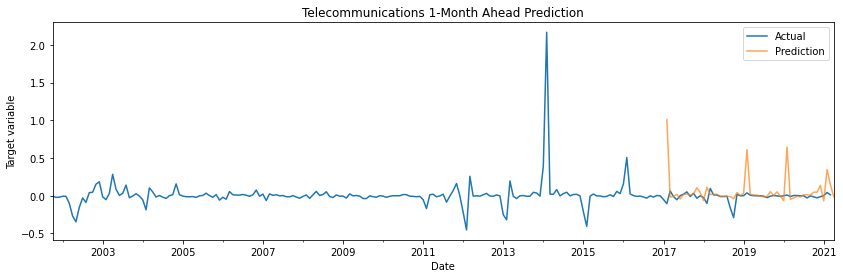

In [48]:
sar1_model = SARIMAX(y_train, 
                order = (1,0,0), 
                seasonal_order = (2,1,0,12)
                , exog = x_train
                )

sar1_mod_fit = sar1_model.fit()

sar1_pred = sar1_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

sar1_pred_mean = sar1_pred.predicted_mean
sar1_pred_ci = sar1_pred.conf_int(alpha = 0.5)
ax = df_1.target.plot(label='Actual')
sar1_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 1-Month Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]


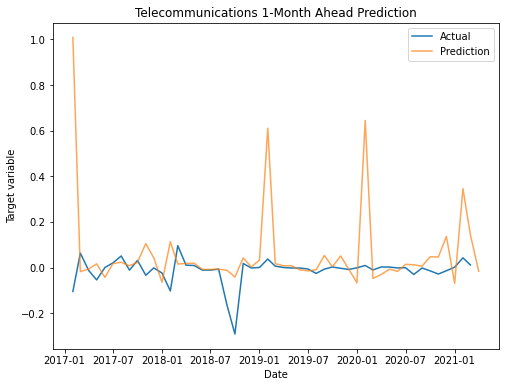

In [49]:
first_date = y_test.index[0]
last_date = y_test.dropna().index[-1]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_1[df_1.index >= first_date].index, df_1[df_1.index >= first_date].target, label = 'Actual')
ax.plot(sar1_pred_mean.index, sar1_pred_mean, label='Prediction', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 1-Month Ahead Prediction')
plt.legend()
plt.show()

In [50]:
def forecast_accuracy(forecast, actual):
    '''
    These are some accuracy metrics we use to compare how accurate our forecast values are.
    '''
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax                
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

In [51]:
metrics1 = forecast_accuracy(y_test[y_test.index < last_date], sar1_pred_mean[sar1_pred_mean.index < last_date])
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

MAPE: 1.56963
MAE: 0.09490


## SARIMA Model - 3 month

In [52]:
var_corr_3 = (df_3.corr().sort_values('target'))
var_corr_3.head()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
cpi_yoy_ch_7,-0.123403,0.258900,-0.046956,-0.300209,-0.254589,0.007477,0.309794,-0.282846,0.005917,-0.107667,...,-0.314092,-0.312365,-0.310461,-0.309413,-0.309996,-0.312036,-0.314950,-0.318122,-0.321456,0.014939
ppi_w_yoy_ch_11,-0.114681,-0.007641,-0.194344,-0.235792,-0.187638,-0.182144,-0.378785,0.624711,0.184090,0.445468,...,0.571176,0.573325,0.573696,0.572590,0.570980,0.569519,0.568298,0.567086,0.565711,-0.009174
cpi_yoy_ch_8,-0.101863,0.267984,-0.052876,-0.334515,-0.273183,0.019052,0.229918,-0.287524,-0.008900,-0.109073,...,-0.317847,-0.316710,-0.314934,-0.313052,-0.312015,-0.312569,-0.314602,-0.317521,-0.320701,0.010142
cpi_yoy_ch_6,-0.099597,0.242031,-0.070508,-0.274702,-0.214365,-0.020136,0.391891,-0.278207,-0.001199,-0.111200,...,-0.309646,-0.307867,-0.306840,-0.307419,-0.309454,-0.312347,-0.315490,-0.318804,-0.322182,0.011905
cpi_mom_ch_8,-0.092180,0.011192,0.103890,-0.049216,-0.073404,-0.064332,0.338816,-0.095879,0.037207,-0.057944,...,-0.100948,-0.101612,-0.103028,-0.105742,-0.110006,-0.115215,-0.119306,-0.121831,-0.123345,-0.096217


In [53]:
var_corr_3.tail()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
exp_mom_ch_1,0.106799,-0.184101,0.013652,0.026121,0.015404,0.198102,0.049930,-0.008150,-0.001263,0.063259,...,-0.081072,-0.068196,-0.060416,-0.059246,-0.060599,-0.061251,-0.060276,-0.057298,-0.053063,-0.019974
ppi_w_yoy_ch_1,0.110531,-0.317144,-0.169814,-0.274051,-0.293096,-0.058252,-0.169810,0.687145,0.010201,0.918835,...,0.592308,0.589509,0.586828,0.584508,0.582323,0.580177,0.577924,0.575895,0.574192,0.012317
imp_mom_ch_6,0.114747,-0.093079,0.093455,0.192341,0.096259,-0.064249,0.297330,-0.165391,-0.027639,-0.054182,...,-0.207988,-0.215237,-0.223190,-0.230213,-0.235628,-0.240247,-0.243904,-0.246300,-0.246512,-0.050380
imp_mom_ch_7,0.144294,-0.116019,0.180457,0.112243,0.128663,-0.028934,0.294774,-0.177568,-0.037054,-0.054115,...,-0.221157,-0.223612,-0.228546,-0.235259,-0.242122,-0.248515,-0.253932,-0.258243,-0.260933,0.025778
target,1.000000,-0.081699,0.039481,0.090343,0.030000,0.019071,-0.046964,0.026172,-0.019308,0.102231,...,0.016382,0.016013,0.015983,0.016031,0.016155,0.016844,0.018396,0.019771,0.020494,-0.015272


In [54]:
model_exvar = ['imp_mom_ch','exp_mom_ch','ppi_w_mom_ch','market3']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_3.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_3.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

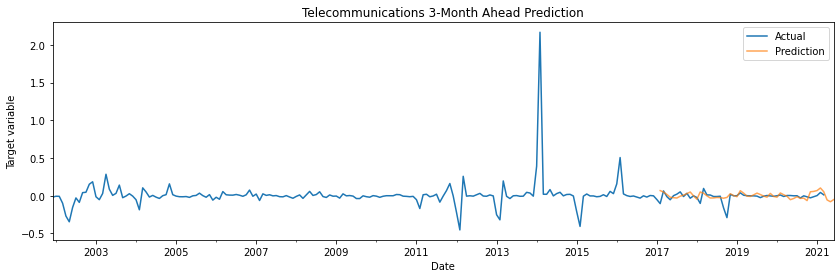

In [55]:
sar3_model = SARIMAX(y_train, 
                order = (0,0,1), 
                seasonal_order = (0,1,1,12)
                , exog = x_train
                )

sar3_mod_fit = sar3_model.fit()

sar3_pred = sar3_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

sar3_pred_mean = sar3_pred.predicted_mean
sar3_pred_ci = sar3_pred.conf_int(alpha = 0.5)
ax = df_3.target.plot(label='Actual')
sar3_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 3-Month Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]


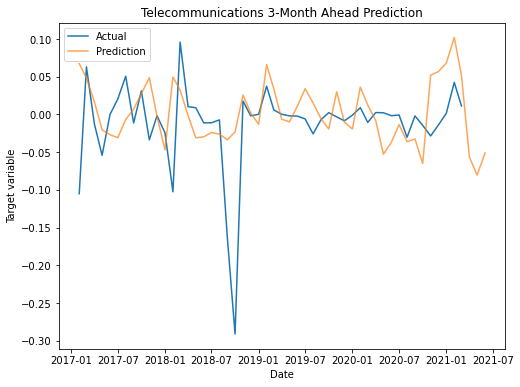

In [56]:
first_date = y_test.index[0]
last_date = y_test.dropna().index[-1]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_3[df_3.index >= first_date].index, df_3[df_3.index >= first_date].target, label = 'Actual')
ax.plot(sar3_pred_mean.index, sar3_pred_mean, label='Prediction', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 3-Month Ahead Prediction')
plt.legend()
plt.show()

In [57]:
metrics1 = forecast_accuracy(y_test[y_test.index < last_date], sar3_pred_mean[sar3_pred_mean.index < last_date])
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

MAPE: 1.69077
MAE: 0.04131


## SARIMA Model - 6 month

In [58]:
var_corr_6 = (df_6.corr().sort_values('target'))
var_corr_6.head()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
market12,-0.123259,1.000000,-0.072189,-0.176613,-0.204440,-0.081843,-0.120736,-0.178896,-0.029952,-0.330086,...,-0.099859,-0.100467,-0.100079,-0.098762,-0.097011,-0.095653,-0.094742,-0.094287,-0.094210,-0.009627
cpi_yoy_ch_4,-0.122854,0.126436,0.069040,-0.186770,-0.142763,-0.096377,0.576598,-0.273317,-0.007526,-0.112257,...,-0.307077,-0.307420,-0.309305,-0.312234,-0.315493,-0.318868,-0.322265,-0.325931,-0.330348,0.013342
ppi_w_yoy_ch_8,-0.115323,-0.062759,-0.195413,-0.250934,-0.187166,-0.241874,-0.292400,0.642605,0.179355,0.542765,...,0.575749,0.574970,0.573639,0.572065,0.570457,0.568767,0.566655,0.564100,0.561201,-0.001474
cpi_yoy_ch_5,-0.101208,0.199861,-0.020889,-0.245821,-0.173997,-0.056360,0.479540,-0.276771,0.001304,-0.109048,...,-0.308277,-0.307159,-0.307640,-0.309650,-0.312608,-0.315785,-0.319113,-0.322486,-0.326153,0.009711
cpi_yoy_ch_3,-0.099041,0.052471,0.134744,-0.076353,-0.102264,-0.158823,0.680856,-0.265993,0.009661,-0.115605,...,-0.305113,-0.307027,-0.309929,-0.313177,-0.316573,-0.319970,-0.323623,-0.328025,-0.333303,0.016355


In [59]:
var_corr_6.tail()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
ppi_w_mom_ch_2,0.089602,-0.069133,-0.088183,-0.071698,-0.079618,-0.020809,-0.058014,0.155321,-0.058214,0.233372,...,0.132563,0.133367,0.134897,0.135536,0.134785,0.133015,0.131569,0.131008,0.131656,-0.024757
ppi_w_mom_ch_6,0.095539,-0.167401,-0.034224,-0.047085,-0.100758,0.070586,-0.015567,0.196347,-0.115368,0.228089,...,0.164388,0.162422,0.161272,0.160498,0.160276,0.160353,0.160902,0.161183,0.160847,0.004465
imp_mom_ch_3,0.114587,-0.160485,0.017640,0.197449,0.175377,0.174206,0.282565,-0.119732,0.015355,-0.026879,...,-0.180424,-0.188796,-0.192765,-0.194226,-0.194220,-0.192914,-0.189450,-0.183889,-0.177258,-0.040587
imp_mom_ch_4,0.144043,-0.109074,-0.002382,0.219530,0.129100,0.061898,0.302972,-0.124695,-0.013266,-0.026870,...,-0.178017,-0.189469,-0.196475,-0.199690,-0.201031,-0.201568,-0.200697,-0.197572,-0.192131,0.037604
target,1.000000,-0.123259,0.014408,0.062510,0.071750,0.036640,-0.030663,0.026659,0.017058,0.075189,...,0.014582,0.014709,0.015404,0.016969,0.018356,0.019084,0.018950,0.019043,0.019698,-0.015420


In [60]:
model_exvar = ['imp_mom_ch','exp_mom_ch','ppi_w_mom_ch','market6']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_6.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_6.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

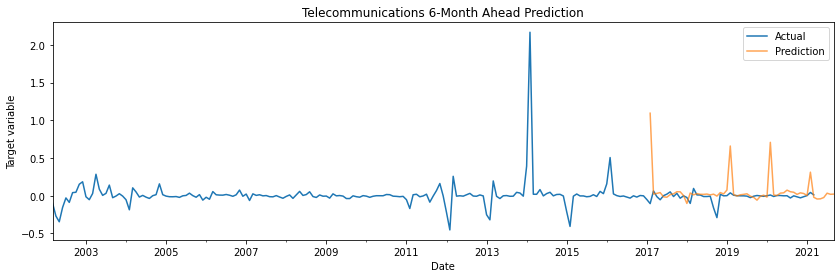

In [61]:
sar6_model = SARIMAX(y_train, 
                order = (0,0,1), 
                seasonal_order = (2,1,0,12)
                , exog = x_train
                )

sar6_mod_fit = sar6_model.fit()

sar6_pred = sar6_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

sar6_pred_mean = sar6_pred.predicted_mean
sar6_pred_ci = sar6_pred.conf_int(alpha = 0.5)
ax = df_6.target.plot(label='Actual')
sar6_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 6-Month Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]


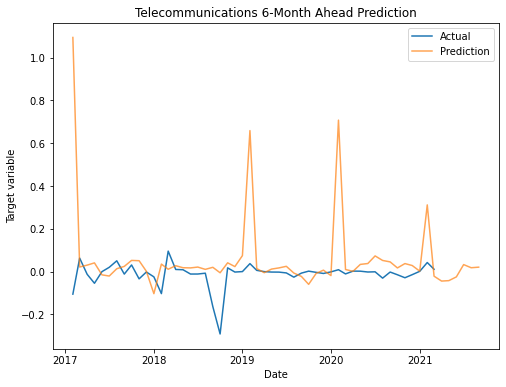

In [62]:
first_date = y_test.index[0]
last_date = y_test.dropna().index[-1]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_6[df_6.index >= first_date].index, df_6[df_6.index >= first_date].target, label = 'Actual')
ax.plot(sar6_pred_mean.index, sar6_pred_mean, label='Prediction', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 6-Month Ahead Prediction')
plt.legend()
plt.show()

In [63]:
metrics1 = forecast_accuracy(y_test[y_test.index < last_date], sar6_pred_mean[sar6_pred_mean.index < last_date])
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

MAPE: 2.70514
MAE: 0.09910


## SARIMAX Model - 12 month

In [64]:
var_corr_12 = (df_12.corr().sort_values('target'))
var_corr_12.head()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
ppi_w_yoy_ch_2,-0.115812,-0.310059,-0.150986,-0.259903,-0.290504,-0.010634,-0.160093,0.690214,0.010328,0.850089,...,0.595455,0.592796,0.589918,0.587282,0.584981,0.582743,0.580574,0.578313,0.576281,0.002890
imp_yoy_ch_6,-0.109524,-0.052745,0.225217,0.101223,0.140153,-0.019430,0.355422,-0.266028,-0.008211,-0.015370,...,-0.362202,-0.362491,-0.366739,-0.373627,-0.381696,-0.389656,-0.397474,-0.404966,-0.411998,-0.006676
ppi_w_mom_ch_2,-0.108305,-0.069133,-0.088183,-0.071698,-0.079618,-0.020809,-0.058014,0.155321,-0.058214,0.233372,...,0.132563,0.133367,0.134897,0.135536,0.134785,0.133015,0.131569,0.131008,0.131656,-0.082077
imp_yoy_ch_5,-0.107177,-0.082389,0.233642,0.136457,0.154311,-0.015463,0.402609,-0.286805,-0.007285,-0.032170,...,-0.382118,-0.384631,-0.390468,-0.398297,-0.406848,-0.415103,-0.422915,-0.430032,-0.436326,-0.017057
imp_yoy_ch_7,-0.099543,-0.033388,0.212025,0.072679,0.133194,-0.004537,0.312400,-0.240605,-0.014673,0.001631,...,-0.339741,-0.338283,-0.340967,-0.346649,-0.353863,-0.361107,-0.368449,-0.375810,-0.383183,-0.001947


In [65]:
var_corr_12.tail()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
cpi_yoy_ch_12,0.081808,0.249280,-0.329922,-0.260864,-0.227112,-0.014516,-0.061400,-0.284258,-0.029015,-0.103166,...,-0.301322,-0.304141,-0.306570,-0.308437,-0.309221,-0.308336,-0.305989,-0.303238,-0.301456,0.008184
exp_mom_ch_11,0.084561,-0.002177,0.056538,-0.042280,-0.135084,-0.114401,0.220213,0.035312,-0.010626,0.092682,...,0.006293,0.008211,0.011097,0.014387,0.014761,0.006401,-0.011693,-0.034954,-0.052841,-0.093922
exp_mom_ch_12,0.110811,0.032813,0.093023,-0.086004,-0.145700,-0.184886,0.116724,0.034281,-0.006272,0.068899,...,0.010586,0.011842,0.012898,0.015308,0.018528,0.019252,0.011129,-0.006846,-0.030152,-0.008744
exp_mom_ch_13,0.120947,0.063676,0.100867,-0.126277,-0.113831,-0.200310,-0.004675,0.033106,0.037268,0.074808,...,0.014243,0.015942,0.016409,0.017025,0.019370,0.022919,0.023901,0.015940,-0.002051,0.033956
target,1.000000,0.070804,-0.079381,-0.024624,0.066445,0.053104,-0.050230,-0.020629,0.063552,-0.069413,...,-0.014177,-0.014137,-0.013527,-0.012604,-0.012542,-0.013370,-0.015152,-0.017560,-0.020509,-0.027297


In [66]:
model_exvar = ['market12','imp_mom_ch','exp_mom_ch','ppi_w_mom_ch']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_12.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_12.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]



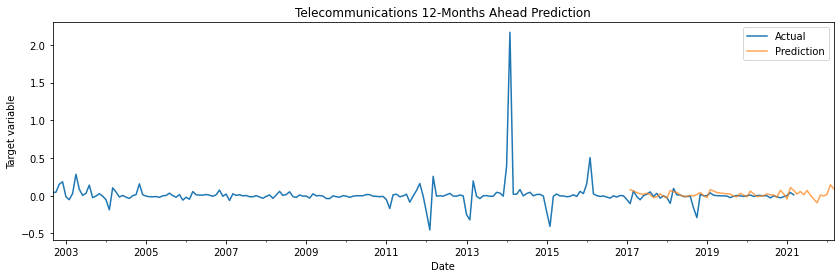

In [67]:
sar12_model = SARIMAX(y_train, 
                order = (0,0,1), 
                seasonal_order = (0,1,1,12)
                , exog = x_train
                )

sar12_mod_fit = sar12_model.fit()

sar12_pred = sar12_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test
                                         )
sar12_pred_mean = sar12_pred.predicted_mean
sar12_pred_ci = sar12_pred.conf_int()
ax = df_12.target.plot(label='Actual')
sar12_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 12-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

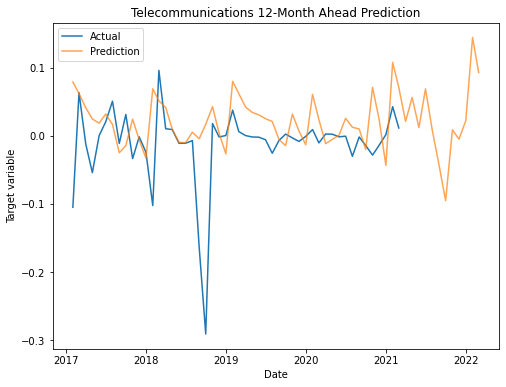

In [68]:
first_date = y_test.index[0]
last_date = y_test.dropna().index[-1]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_12[df_12.index >= first_date].index, df_12[df_12.index >= first_date].target, label = 'Actual')
ax.plot(sar12_pred_mean.index, sar12_pred_mean, label='Prediction', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 12-Month Ahead Prediction')
plt.legend()
plt.show()

In [69]:
metrics1 = forecast_accuracy(y_test, sar12_pred_mean)
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

MAPE: 2.27169
MAE: 0.04337


## SARIMAX Model - 18 month

In [70]:
var_corr_18 = (df_18.corr().sort_values('target'))
var_corr_18.head()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
imp_yoy_ch,-0.106142,-0.267624,0.209094,0.296750,0.294700,0.125321,0.514340,-0.330637,-0.022910,-0.070529,...,-0.443485,-0.452494,-0.460083,-0.466187,-0.470899,-0.474492,-0.476897,-0.478035,-0.477681,0.006379
ppi_w_mom_ch_7,-0.095106,-0.128537,-0.029107,-0.048635,-0.089758,-0.071826,-0.028706,0.189414,0.042963,0.278818,...,0.160140,0.159381,0.157705,0.156740,0.155995,0.155636,0.155609,0.156080,0.156329,0.021479
imp_yoy_ch_1,-0.094004,-0.244220,0.226683,0.269271,0.269528,0.092700,0.527713,-0.323498,-0.023682,-0.064861,...,-0.432636,-0.441646,-0.449939,-0.457175,-0.463230,-0.468223,-0.472059,-0.474672,-0.475904,0.018116
cpi_mom_ch_3,-0.090290,-0.106341,0.125009,0.333727,0.050407,-0.113099,0.334024,-0.062907,-0.011585,-0.043462,...,-0.093411,-0.097656,-0.100048,-0.101230,-0.102177,-0.102322,-0.101632,-0.101081,-0.100847,-0.036300
imp_mom_ch_10,-0.085972,-0.069538,0.165337,0.010657,0.069834,-0.010904,0.214157,-0.151209,0.057236,-0.002626,...,-0.192365,-0.195366,-0.197969,-0.199758,-0.202409,-0.206816,-0.212779,-0.219391,-0.225716,0.020902


In [71]:
var_corr_18.tail()

,target,market12,market6,market3,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
exp_mom_ch_7,0.119230,-0.130013,-0.098511,-0.021882,0.022245,-0.023499,0.201296,0.005687,0.094379,0.115859,...,-0.020420,-0.027869,-0.046759,-0.071398,-0.089879,-0.098280,-0.097602,-0.094283,-0.091783,0.031724
cpi_yoy_ch_11,0.124990,0.261622,-0.280032,-0.300085,-0.228583,0.022016,0.005331,-0.285688,-0.019186,-0.097925,...,-0.308990,-0.310439,-0.311716,-0.312395,-0.311932,-0.309920,-0.307441,-0.305779,-0.305974,-0.008730
cpi_yoy_ch_12,0.130956,0.249280,-0.329922,-0.260864,-0.227112,-0.014516,-0.061400,-0.284258,-0.029015,-0.103166,...,-0.301322,-0.304141,-0.306570,-0.308437,-0.309221,-0.308336,-0.305989,-0.303238,-0.301456,-0.001666
cpi_yoy_ch_13,0.133759,0.206765,-0.354190,-0.233071,-0.217297,0.013063,-0.057573,-0.287662,-0.044147,-0.126074,...,-0.300471,-0.303485,-0.306179,-0.308578,-0.310447,-0.311249,-0.310388,-0.308061,-0.305314,0.003070
target,1.000000,0.080745,-0.002886,-0.015407,-0.076387,0.033691,-0.017803,-0.004632,-0.019419,-0.043652,...,-0.005478,-0.007902,-0.010901,-0.014170,-0.015860,-0.016237,-0.015095,-0.013761,-0.012246,-0.045393


In [72]:
model_exvar = ['market12','imp_mom_ch','exp_mom_ch','ppi_w_mom_ch']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_18.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_18.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]



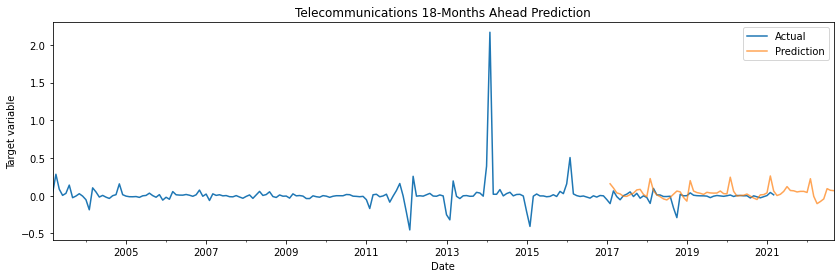

In [73]:
sar18_model = SARIMAX(y_train, 
                order = (0,0,1), 
                seasonal_order = (0,1,2,12)
                , exog = x_train
                )

sar18_mod_fit = sar18_model.fit()

sar18_pred = sar18_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test
                                         )
sar18_pred_mean = sar18_pred.predicted_mean
sar18_pred_ci = sar18_pred.conf_int()
ax = df_18.target.plot(label='Actual')
sar18_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 18-Months Ahead Prediction')
plt.legend()
plt.show()

last_date = y_test.dropna().index[-1]

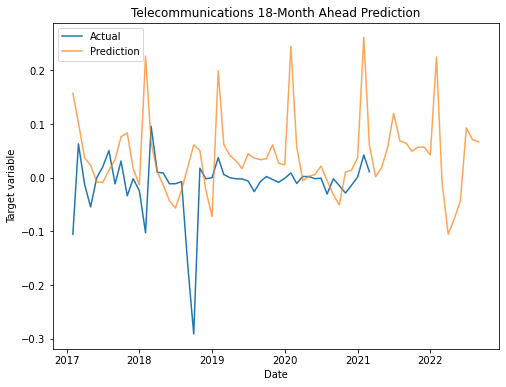

In [74]:
first_date = y_test.index[0]
last_date = y_test.dropna().index[-1]


fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(df_18[df_18.index >= first_date].index, df_18[df_18.index >= first_date].target, label = 'Actual')
ax.plot(sar18_pred_mean.index, sar18_pred_mean, label='Prediction', alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 18-Month Ahead Prediction')
plt.legend()
plt.show()

In [75]:
metrics1 = forecast_accuracy(y_test, sar18_pred_mean)
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

MAPE: 1.52858
MAE: 0.06618


## Future Forecast

In [76]:
pred18 = pd.DataFrame(sar18_pred_mean).rename(columns = {'predicted_mean' : 'pred18'})
pred18.index = pred18.index.rename('date')
pred12 = pd.DataFrame(sar12_pred_mean).rename(columns = {'predicted_mean' : 'pred12'})
pred12.index = pred12.index.rename('date')
pred1 = pd.DataFrame(sar1_pred_mean).rename(columns = {'predicted_mean' : 'pred1'})
pred1.index = pred1.index.rename('date')

In [77]:
pred_joined = pred18.join(pred12).join(pred1)
pred_joined

,pred18,pred12,pred1
date,,,
2017-02-01,0.157598,0.078897,1.008121
2017-03-01,0.101981,0.061965,-0.017941
2017-04-01,0.037267,0.040967,-0.006286
2017-05-01,0.023304,0.024586,0.016498
2017-06-01,-0.007614,0.018393,-0.043045
...,...,...,...
2022-05-01,-0.077064,NaN,NaN
2022-06-01,-0.042917,NaN,NaN
2022-07-01,0.092820,NaN,NaN


In [78]:
pred_joined['combined_pred'] = pred_joined.pred1.fillna(pred_joined.pred12).fillna(pred_joined.pred18)
pred_joined

,pred18,pred12,pred1,combined_pred
date,,,,
2017-02-01,0.157598,0.078897,1.008121,1.008121
2017-03-01,0.101981,0.061965,-0.017941,-0.017941
2017-04-01,0.037267,0.040967,-0.006286,-0.006286
2017-05-01,0.023304,0.024586,0.016498,0.016498
2017-06-01,-0.007614,0.018393,-0.043045,-0.043045
...,...,...,...,...
2022-05-01,-0.077064,NaN,NaN,-0.077064
2022-06-01,-0.042917,NaN,NaN,-0.042917
2022-07-01,0.092820,NaN,NaN,0.092820


In [79]:
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

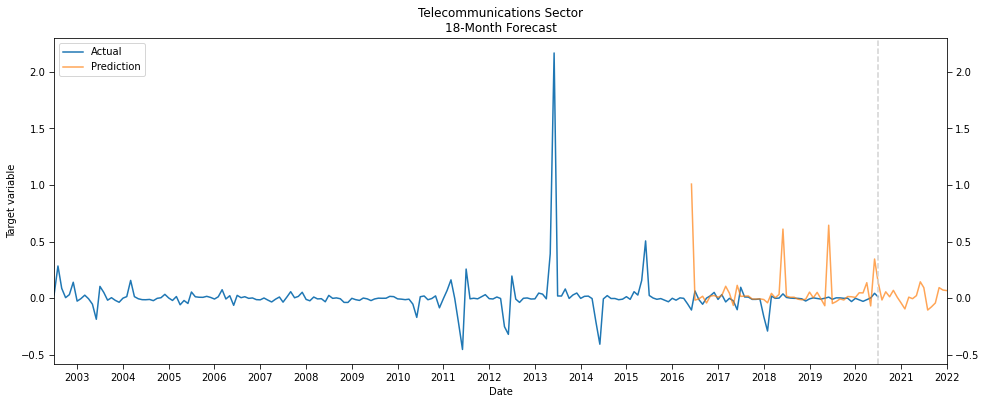

In [80]:
# plot inputs
fig, ax = plt.subplots(figsize=(16, 6))
ax.plot(df_18.index, df_18.target, label = 'Actual')
ax.plot(pred_joined.index, pred_joined.combined_pred, label='Prediction', alpha=.7)
ax.axvline(df_18.dropna().index[-1], c = 'lightgrey', linestyle = '--')

# format the axes
ax.xaxis.set_major_formatter(DateFormatter("%Y")) 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval = 12))

ax.yaxis.set_ticks_position('both')
ax.tick_params(length = 5, axis = 'both', labelright = True, direction = 'out')

ax.margins(x=0) # remove whitespace

# labels
ax.set(xlabel = 'Date', ylabel = 'Target variable', 
       title = 'Telecommunications Sector\n18-Month Forecast')

plt.legend()
plt.show()